# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.utils.vis_utils import plot_model

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [ ]:
!pip install keras-flops
from keras_flops import get_flops


# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  class_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, class_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [ ]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.Input(shape=(28,28,1)))
cnn_model.add(tf.keras.layers.Conv2D(32, 3, strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=1))
cnn_model.add(tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(10))


# your code start from here for stpe 2


# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.Input(shape=(28,28,1)))
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(10))



# your code start from here for step 2


In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for classes.
  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, class_logits))

  return cross_entropy_loss_value

# Student loss function

In [ ]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = ALPHA * student_loss + (1 - ALPHA) * distillation_loss_value
  
  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.
  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.
  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)

  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)
      #print(loss_value)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a,b,c = compute_num_correct(model, images, labels)
      num_correct += a
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

# Training models

In [ ]:
# your code start from here for step 5 
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 99.22%
Epoch 2: Class_accuracy: 99.16%
Epoch 3: Class_accuracy: 99.17%
Epoch 4: Class_accuracy: 99.29%
Epoch 5: Class_accuracy: 99.29%
Epoch 6: Class_accuracy: 99.20%
Epoch 7: Class_accuracy: 99.21%
Epoch 8: Class_accuracy: 99.29%
Epoch 9: Class_accuracy: 99.25%
Epoch 10: Class_accuracy: 99.35%
Epoch 11: Class_accuracy: 99.28%
Epoch 12: Class_accuracy: 99.36%


In [ ]:
train_and_evaluate(fc_model,compute_student_loss)

Epoch 1: Class_accuracy: 96.56%
Epoch 2: Class_accuracy: 97.72%
Epoch 3: Class_accuracy: 98.14%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.53%
Epoch 7: Class_accuracy: 98.64%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.69%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.67%
Epoch 12: Class_accuracy: 98.75%


INFO:tensorflow:Assets written to: <keras.engine.sequential.Sequential object at 0x7fd633e69290>/assets


INFO:tensorflow:Assets written to: <keras.engine.sequential.Sequential object at 0x7fd633e69290>/assets


# Test accuracy vs. tempreture curve

In [ ]:
def compute_student_loss_plot(images, labels, T, alpha=0.5):
  
  student_class_logits = fc_model(images, training=True)

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, T)

  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = alpha * student_loss + (1 - alpha) * distillation_loss_value
  
  return cross_entropy_loss_value

def train_and_evaluate_plot(model, compute_loss_fn, T, alpha=0.5):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels, T, alpha=0.5)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:

      a,b,c = compute_num_correct(model, images, labels)
      num_correct += a
    # print("Class_accuracy: " + '{:.2f}%'.format(
    #     num_correct / num_total * 100))
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy


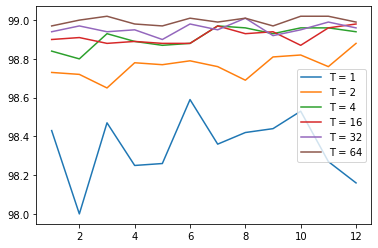

In [ ]:
# your code start from here for step 6
T = [1,2,4,16,32,64]
epoch = [i for i in range(1,13)]
handles = []

for i in T:
  test_accuracy = train_and_evaluate_plot(fc_model,compute_student_loss_plot, i)
  temp = str(i)
  temp,  = plt.plot(epoch, test_accuracy, label=f'T = {i}')
  handles.append(temp)

plt.legend(handles=handles)
plt.show()

It looks like when holding alpha constant, increasing T gives a better accuracy. This is intended because a high temperature gives higher entropy and therefore provides more information for training the smaller model. Therefore, a higher T should give higher accuracy.

Now, with the best T (=64), we try different alpha values for fine-tuning, and these alphavalues include 0.1 to 0.9 (increment by 0.1).

In [ ]:
def compute_student_loss_plot(images, labels, alpha):
  
  student_class_logits = fc_model(images, training=True)

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, 64)

  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = alpha * student_loss + (1 - alpha) * distillation_loss_value
  
  return cross_entropy_loss_value

def train_and_evaluate_plot(model, compute_loss_fn, alpha):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels, alpha)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:

      a,b,c = compute_num_correct(model, images, labels)
      num_correct += a
    # print("Class_accuracy: " + '{:.2f}%'.format(
    #     num_correct / num_total * 100))
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy

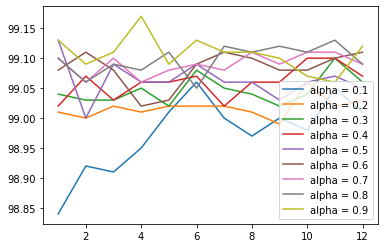

In [ ]:
# your code start from here for step 6
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
epoch = [i for i in range(1,13)]
handles = []

for i in alpha:
  test_accuracy = train_and_evaluate_plot(fc_model,compute_student_loss_plot, i)
  alpha = str(i)
  alpha,  = plt.plot(epoch, test_accuracy, label=f'alpha = {i}')
  handles.append(alpha)

plt.legend(handles=handles)
plt.show()

From the graph above, it looks like alpha=0.9 is the best choice.

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.Input(shape=(28,28,1)))
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over classes, but does not perform class distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7
  student_class_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits) 
  return cross_entropy_loss

train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.89%
Epoch 2: Class_accuracy: 97.65%
Epoch 3: Class_accuracy: 97.84%
Epoch 4: Class_accuracy: 97.83%
Epoch 5: Class_accuracy: 97.51%
Epoch 6: Class_accuracy: 97.99%
Epoch 7: Class_accuracy: 97.58%
Epoch 8: Class_accuracy: 98.21%
Epoch 9: Class_accuracy: 97.85%
Epoch 10: Class_accuracy: 98.30%
Epoch 11: Class_accuracy: 98.09%
Epoch 12: Class_accuracy: 97.99%


In [ ]:
ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 64 #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  student_class_logits = fc_model(images, training=True)
  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, DISTILLATION_TEMPERATURE)
  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = ALPHA * student_loss + (1 - ALPHA) * distillation_loss_value
  return cross_entropy_loss_value

@tf.function
def compute_num_correct(model, images, labels):
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def train_and_evaluate(model, compute_loss_fn):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)
      #print(loss_value)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a,b,c = compute_num_correct(model, images, labels)
      num_correct += a
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

In [ ]:
train_and_evaluate(fc_model,compute_student_loss)

Epoch 1: Class_accuracy: 97.58%
Epoch 2: Class_accuracy: 98.20%
Epoch 3: Class_accuracy: 98.44%
Epoch 4: Class_accuracy: 98.46%
Epoch 5: Class_accuracy: 98.58%
Epoch 6: Class_accuracy: 98.62%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.75%
Epoch 9: Class_accuracy: 98.69%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.72%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
flops = get_flops(cnn_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.022 G


In [ ]:
flops = get_flops(fc_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.00248 G


In [ ]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 7744)              0         
                                                                 
 dropout_2 (Dropout)         (None, 7744)             

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


Although the student has more parameters than the teacher, the student model's flop is a degree of smaller than the teacher model. 

# XAI method to explain models

In [ ]:
# your code start from here for step 9
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# need to replace this with your own directory
os.chdir(r'/content/drive/My Drive/Colab Notebooks/1512')

In [ ]:
from xai_utils import *

(28, 28)


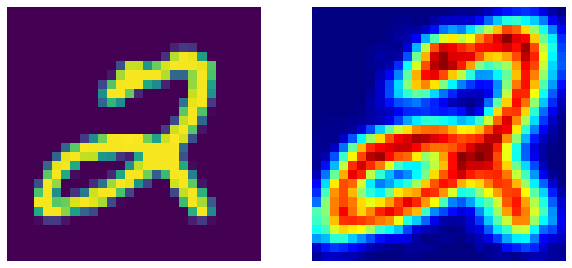

In [ ]:
# XAI on the teacher model.
for image, label in mnist_test:
  cam = grad_cam(cnn_model, np.expand_dims(image[0].numpy(), axis=0), 'conv2d_1')
  #print(cam.shape)
  cam = (cam*255).astype("uint8")
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  img = cam + image[0].numpy()
  img = np.clip(img,0,255).astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(image[0].numpy().reshape(28,28))
  ax[1].imshow(img)
  ax[0].axis('off')
  ax[1].axis('off')
  break

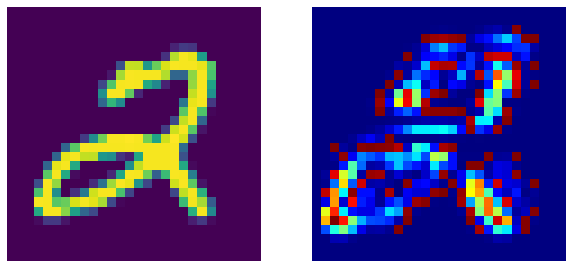

In [ ]:
# XAI on the student model.
for image, label in mnist_test:
  cam = grad_cam(fc_model, np.expand_dims(image[0].numpy(), axis=0), 'conv2d_5')
  #print(cam.shape)
  cam = (cam*255).astype("uint8")
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  img = cam + image[0].numpy()
  img = np.clip(img,0,255).astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(image[0].numpy().reshape(28,28))
  ax[1].imshow(img)
  ax[0].axis('off')
  ax[1].axis('off')
  break

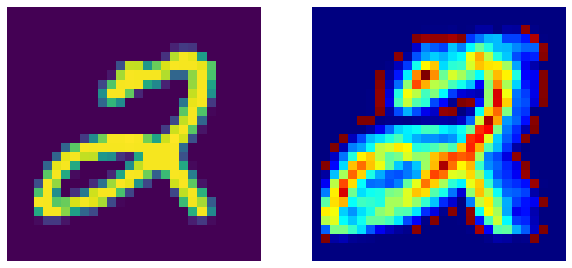

In [ ]:
# XAI on the distilled model.
for image, label in mnist_test:
  cam = grad_cam(fc_model, np.expand_dims(image[0].numpy(), axis=0), 'conv2d_3')
  #print(cam.shape)
  cam = (cam*255).astype("uint8")
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  img = cam + image[0].numpy()
  img = np.clip(img,0,255).astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(image[0].numpy().reshape(28,28))
  ax[1].imshow(img)
  ax[0].axis('off')
  ax[1].axis('off')
  break

# 10. Now that you have had a chance to implement, understand, and train the teacher and student
models in the KD framework, you will use the state-of-the-arts KD algorithm to improve the
performance of the student model. Read only one of the following papers- [10, 9, 13, 12, 3, 16, 7,
11, 2]. What is the main novel idea of the paper? [2 Marks]

The algorithm that we are implementing is the teacher assistant knowledge distillation.

Seyed Iman Mirzadeh, Mehrdad Farajtabar, Ang Li, Nir Levine, Akihiro Matsukawa, and Hassan Ghasemzadeh. Improved knowledge distillation via teacher assistant. In Proceedings of the AAAI Conference on Artificial Intelligence, volume 34, pages 5191–5198, 2020. https://ojs.aaai.org/ index.php/AAAI/article/view/5963/5819.

The key idea of this algorithm is to use a intermediate-sized teacher assistant(TA) model to fill the gap between the large teacher model and the smaller student model. When the difference between the teacher and student's size gets bigger, the student network may not perform well. The reason is when the teacher model becomes so complex, the small student model would not have enough DOF or capacity to mimic the teacher's behavior.

Therefore, this huge gap between the teacher and student cannot provide much useful distilled knowledge to supervise student's learning.

# How does the proposed method improve the student performance in comparison to the conventional KD? [2 Marks]

The proposed model introduced an intermediate TA model that helps to fill the gap between the bigger teacher and the smaller student. When there is a huge difference in the number of layers between the student and teacher, using a TA could bridge the difference the extent of soft targets from the teacher model to a much smaller student model.

# What are some limitations of the proposed method? How can they be addressed? [2 Marks]

One limitation of this TA approach is that the structure (best size) of the TA cannot be easily determined. Another limitation is that when using this approach in our case where a not so big teacher and a not too small student were used, the improvement can be minimal. One last limitation is that the number of TA to be used cannot be easily determined either. If using this approache on a enormous teacher paired with a extremely tiny student, it can be difficult to set the number of TA to be used. In other words, the distillation path can be difficult to determined according to the original paper.

One way to address these issues it that we can do experiments based on trials-and-errors. Once we set up the number of TA and the TA structure, we can keep adjusting these parameters and find out what are the best parameters to use.

# Implementing the state-of-the-art KD algorithm

The algorithm that we are implementing is the teacher assistant knowledge distillation.

Seyed Iman Mirzadeh, Mehrdad Farajtabar, Ang Li, Nir Levine, Akihiro Matsukawa, and Hassan
Ghasemzadeh. Improved knowledge distillation via teacher assistant. In Proceedings of the AAAI
Conference on Artificial Intelligence, volume 34, pages 5191–5198, 2020. https://ojs.aaai.org/
index.php/AAAI/article/view/5963/5819.

The key idea of this algorithm is to use a intermediate-sized teacher assistant(TA) model to fill the gap between the large teacher model and the smaller student model. When the difference between the teacher and student's size gets bigger, the student network may not perform well. The reason is when the teacher model becomes so complex, the small student model would not have enough DOF or capacity to mimic the teacher's behavior.

Therefore, this huge gap between the teacher and student cannot provide much useful distilled knowledge to supervise student's learning.



In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


Since the teacher model has 2 conv layers and the student is fully connected. We decided to create a intermediate TA model that has 1 conv layer to fill the gap.

In [ ]:
# Build TA model.
ta_model = tf.keras.Sequential()
ta_model.add(tf.keras.Input(shape=(28,28,1)))
ta_model.add(tf.keras.layers.Conv2D(32, 3, strides=1, activation='relu'))
ta_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=1))
ta_model.add(tf.keras.layers.Flatten())
ta_model.add(tf.keras.layers.Dropout(0.5))
ta_model.add(tf.keras.layers.Dense(128, activation='relu'))
ta_model.add(tf.keras.layers.Dropout(0.5))
ta_model.add(tf.keras.layers.Dense(10))

In [ ]:
ta_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 20000)             0         
                                                                 
 dropout_4 (Dropout)         (None, 20000)             0         
                                                                 
 dense_25 (Dense)            (None, 128)               2560128   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

Next, we will train the teacher's model as usual and then transfer the knowledge to the intermediate TA model.

In [ ]:
# train the teacher model
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.22%
Epoch 2: Class_accuracy: 98.59%
Epoch 3: Class_accuracy: 99.01%
Epoch 4: Class_accuracy: 99.11%
Epoch 5: Class_accuracy: 99.03%
Epoch 6: Class_accuracy: 99.09%
Epoch 7: Class_accuracy: 99.12%
Epoch 8: Class_accuracy: 99.20%
Epoch 9: Class_accuracy: 99.08%
Epoch 10: Class_accuracy: 99.23%
Epoch 11: Class_accuracy: 99.24%
Epoch 12: Class_accuracy: 99.32%


Next, we are going to train the TA model using the distilled knowledge from the teacher.

In [ ]:
# Slightly change the parameters in order to train the TA model.
# Also change the hyperparameter to the most optimized one

ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 64

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  student_class_logits = ta_model(images, training=True)
  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, DISTILLATION_TEMPERATURE)
  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = ALPHA * student_loss + (1 - ALPHA) * distillation_loss_value
  
  return cross_entropy_loss_value

In [ ]:
train_and_evaluate(ta_model,compute_student_loss)

Epoch 1: Class_accuracy: 97.02%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 98.12%
Epoch 4: Class_accuracy: 98.31%
Epoch 5: Class_accuracy: 98.42%
Epoch 6: Class_accuracy: 98.42%
Epoch 7: Class_accuracy: 98.42%
Epoch 8: Class_accuracy: 98.45%
Epoch 9: Class_accuracy: 98.55%
Epoch 10: Class_accuracy: 98.59%
Epoch 11: Class_accuracy: 98.66%
Epoch 12: Class_accuracy: 98.65%


Now, the TA model is trained, we then train the student model.

In [ ]:
# Slightly change the parameters in order to train the TA model.
# Also change the hyperparameter to the most optimized one

ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 64

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  student_class_logits = fc_model(images, training=True)
  teacher_class_logits = ta_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, DISTILLATION_TEMPERATURE)
  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = ALPHA * student_loss + (1 - ALPHA) * distillation_loss_value
  
  return cross_entropy_loss_value

In [ ]:
train_and_evaluate(fc_model,compute_student_loss)

Epoch 1: Class_accuracy: 96.66%
Epoch 2: Class_accuracy: 97.93%
Epoch 3: Class_accuracy: 98.15%
Epoch 4: Class_accuracy: 98.31%
Epoch 5: Class_accuracy: 98.41%
Epoch 6: Class_accuracy: 98.45%
Epoch 7: Class_accuracy: 98.45%
Epoch 8: Class_accuracy: 98.53%
Epoch 9: Class_accuracy: 98.56%
Epoch 10: Class_accuracy: 98.58%
Epoch 11: Class_accuracy: 98.61%
Epoch 12: Class_accuracy: 98.70%


We see that the increase in accuracy is not significant. Only 0.05% from the TA model. But it's still better than training the student from scratch. Our guess is that because the student and teacher model do not have too big a difference in terms of number of layers, and therefore using a TA in between does not has significant impact. However, it is clear that the accuracy is still better.

# 1(a) What is the purpose of using KD in this paper? [0.5 Marks]

The paper used KD to train a smaller model that is more compact and resource efficient than the original cumbersome model while mainiting comparable accuracy. The cumbersome model can be trained by using as many computation resources as possible, but deploying on some end-user's machine may not be possible. By using KD, this cumbersome model can be replaced by a smaller model which can be easily deployed. In other words, KD is used to transfer the generalization ability from a bigger model to a smaller model.

# 1(b) In the paper, what knowledge is transferred from the teacher model to the student model? [0.5 Marks]

The knowledge transfered from the teacher to the student is the class probabilities (soften by the temperature), in other words, divide the logits by a tempeture value and feed it to the softmax, the new result from the softmax is what being transfered.

# 1(c) What is the temperature hyperparameter T? Why do we use it when transferring knowledge from one model to another? What effect does the temperature hyperparameter have in KD? [0.5 Marks]

T is a hyperparameter that is used to devide the logit by before feeding it to the softmax layer (softmax(f(xi)/T). We use T to smooth the labeling. When a model is highly confident about one class and the class probability for other classes is small, by using a larger T, we can get a relatively smoother (balanced) results and the entropy is increased comparing to without using T (or small T). In KD, this T allows distilled knowledge to be transfered.

# (d) Explain in detail the loss functions on which the teacher and student model are trained in this paper. How does the task balance parameter affect student learning? [0.5 Marks]

The teacher uses cross-entropy loss on the one-hot encoder from the image.
The student uses a cross-entropy plus a distillation object. The task balance parameter is the weighting between cross-entropy and distillation loss. Since the equation is alpha * student_loss + (1 - alpha) * distillation_loss_value. Therefore, a small value of alpha emphasises more on the distillation (1 minus something small is big) meaning that more distilled knowledge is used to train the student. Otherwise, less distilled knowledge is used.

# (e) Can we look at the KD as a regularization technique, here? Explain your rationale. [0.5 Marks]

kD is a form of regularization because it smooths the labels and therefore regularizing the model's classification layer.